In [6]:
library(tseries)
library(xts)
library(fGarch)
library(readxl)

Warning message:
"package 'readxl' was built under R version 3.6.3"

In [3]:
garchAutoTryFit = function(
  ll,
  data,
  trace=FALSE,
  forecast.length=1,
  with.forecast=TRUE,
  ic="AIC",
  garch.model="garch" )
{
  formula = as.formula( paste( sep="",
                               "~ arma(", ll$order[1], ",", ll$order[2], ")+",
                               garch.model,
                               "(", ll$order[3], ",", ll$order[4], ")" ) )
  fit = tryCatch( garchFit( formula=formula,
                            data=data,
                            trace=FALSE,
                            cond.dist=ll$dist ),
                  error=function( err ) TRUE,
                  warning=function( warn ) FALSE )
  
  pp = NULL
  
  if( !is.logical( fit ) ) {
    if( with.forecast ) {
      pp = tryCatch( predict( fit,
                              n.ahead=forecast.length,
                              doplot=FALSE ),
                     error=function( err ) FALSE,
                     warning=function( warn ) FALSE )
      if( is.logical( pp ) ) {
        fit = NULL
      }
    }
  } else {
    fit = NULL
  }
  
  if( trace ) {
    if( is.null( fit ) ) {
      cat( paste( sep="",
                  "   Analyzing (", ll$order[1], ",", ll$order[2],
                  ",", ll$order[3], ",", ll$order[4], ") with ",
                  ll$dist, " distribution done.",
                  "Bad model.\n" ) )
    } else {
      if( with.forecast ) {
        cat( paste( sep="",
                    "   Analyzing (", ll$order[1], ",", ll$order[2], ",",
                    ll$order[3], ",", ll$order[4], ") with ",
                    ll$dist, " distribution done.",
                    "Good model. ", ic, " = ", round(fit@fit$ics[[ic]],6),
                    ", forecast: ",
                    paste( collapse=",", round(pp[,1],4) ), "\n" ) )
      } else {
        cat( paste( sep="",
                    "   Analyzing (", ll[1], ",", ll[2], ",", ll[3], ",", ll[4], ") with ",
                    ll$dist, " distribution done.",
                    "Good model. ", ic, " = ", round(fit@fit$ics[[ic]],6), "\n" ) )
      }
    }
  }
  
  return( fit )
}

garchAuto = function(
  xx,
  min.order=c(0,0,1,1),
  max.order=c(5,5,2,2),
  trace=FALSE,
  cond.dists="sged",
  with.forecast=TRUE,
  forecast.length=1,
  arma.sum=c(0,1e9),
  cores=1,
  ic="AIC",
  garch.model="garch" )
{
  require( fGarch )
  require( parallel )
  
  len = NROW( xx )
  
  models = list( )
  
  for( dist in cond.dists )
    for( p in min.order[1]:max.order[1] )
      for( q in min.order[2]:max.order[2] )
        for( r in min.order[3]:max.order[3] )
          for( s in min.order[4]:max.order[4] )
          {
            pq.sum = p + q
            if( pq.sum <= arma.sum[2] && pq.sum >= arma.sum[1] )
            {
              models[[length( models ) + 1]] = list( order=c( p, q, r, s ), dist=dist )
            }
          }
  
  res = mclapply( models,
                  garchAutoTryFit,
                  data=xx,
                  trace=trace,
                  ic=ic,
                  garch.model=garch.model,
                  forecast.length=forecast.length,
                  with.forecast=TRUE,
                  mc.cores=cores )
  
  best.fit = NULL
  
  best.ic = 1e9
  for( rr in res )
  {
    if( !is.null( rr ) )
    {
      current.ic = rr@fit$ics[[ic]]
      if( current.ic < best.ic )
      {
        best.ic = current.ic
        best.fit = rr
      }
    }
  }
  
  if( best.ic < 1e9 )
  {
    return( best.fit )
  }
  
  return( NULL )
    }

In [4]:
data_frame_to_xts <- function(df, ...){
  df <- as.data.frame(df) 
  #df$date = as.Date(df$date) 
  ts = xts(df[,-1], order.by = df[,1]) 
  return(ts) }

In [7]:
Corona <- read_excel("C:/Users/Митя/Desktop/Corona.xlsx")

In [8]:
df <- Corona

In [9]:
Corona <- data_frame_to_xts(Corona)

In [10]:
adf.test(Corona)

Warning message in adf.test(Corona):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  Corona
Dickey-Fuller = -4.6114, Lag order = 2, p-value = 0.01
alternative hypothesis: stationary


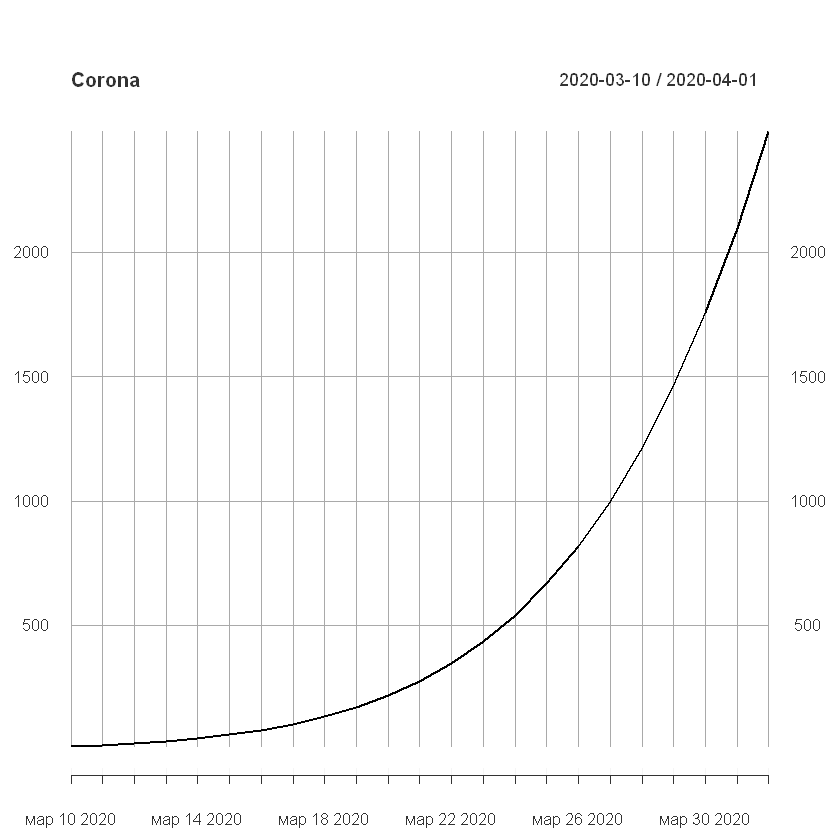

In [11]:
plot(Corona)

In [12]:
lag = 2
Corona <- diff(log(Corona), lag = lag)
Corona <- Corona[-c(1:lag),]
adf.test(Corona)


	Augmented Dickey-Fuller Test

data:  Corona
Dickey-Fuller = -1.5851, Lag order = 2, p-value = 0.7305
alternative hypothesis: stationary


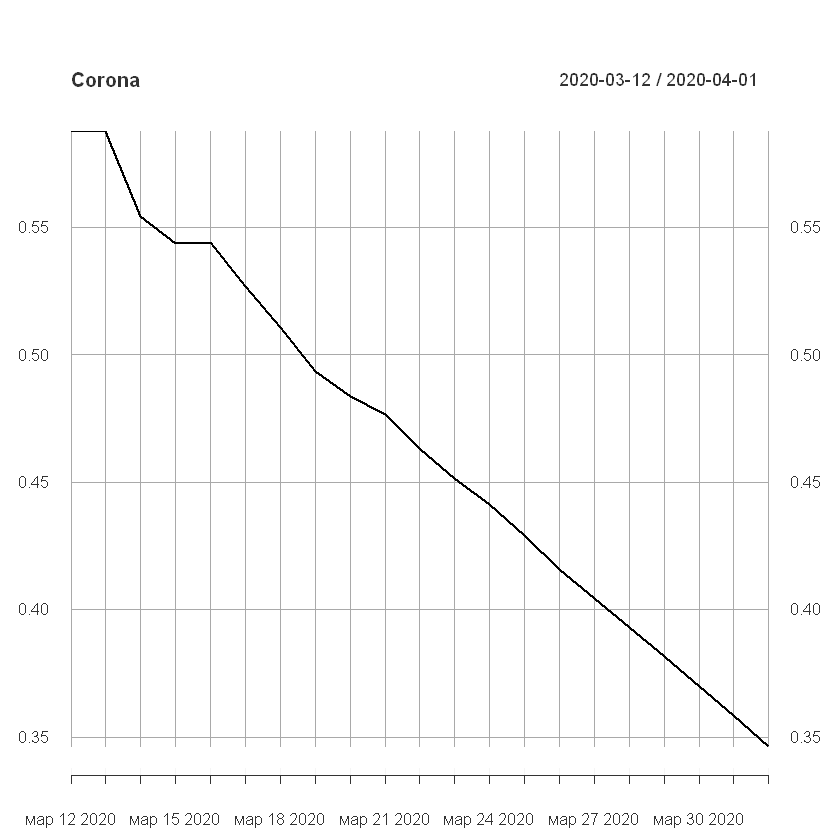

In [13]:
plot(Corona)

In [14]:
m1 <- garchAuto(Corona, with.forecast = TRUE, forecast.length = 100, trace = FALSE)

Loading required package: parallel


In [16]:
summary(m1)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = data, cond.dist = ll$dist, 
    trace = FALSE) 

Mean and Variance Equation:
 data ~ arma(1, 5) + garch(1, 2)
<environment: 0x000000004be64818>
 [data = data]

Conditional Distribution:
 sged 

Coefficient(s):
         mu          ar1          ma1          ma2          ma3          ma4  
-1.9313e-03   9.7102e-01   7.3493e-01   3.9766e-01   6.0996e-01   4.9719e-01  
        ma5        omega       alpha1        beta1        beta2         skew  
 1.7927e-01   5.6269e-09   1.0000e+00   1.0000e-08   1.0000e-08   2.1734e+00  
      shape  
 1.0000e+00  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu     -1.931e-03   7.973e-05  -24.223   <2e-16 ***
ar1     9.710e-01   2.906e-04 3340.981   <2e-16 ***
ma1     7.349e-01   7.970e-03   92.215   <2e-16 ***
ma2     3.977e-01   5.975e-03   66.552   <2e-16 ***
ma3     6.100e-01   5.599e-03  108.937   <2e-16 ***
ma4     4.972e-

In [44]:
PRED <- predict(m1, n.ahead = 100)[1:100,1]
PRED <- as.data.frame(PRED)

In [45]:
tom = as.Date('2020-04-02')

In [46]:
dates_for_pred <- NULL
dates_for_pred <- as.data.frame(dates_for_pred)
for (i in 1:100) {
  dates_for_pred[i,1] <- tom + i -1
}

In [47]:
PRED <- cbind(dates_for_pred, PRED)
colnames(PRED) <- c('Date', 'Val')
PRED <- data_frame_to_xts(PRED)

In [48]:
REAL_PRED <- rbind(Corona, PRED)

In [49]:
rows <- df[1:2,]
rows <- data_frame_to_xts(rows)
REAL_PRED <- rbind(rows, REAL_PRED)

In [50]:
for (i in 3:nrow(REAL_PRED)) {
  REAL_PRED[i] <- as.numeric(REAL_PRED[(i-2)])*exp(as.numeric(REAL_PRED[i]))
}

In [53]:
REAL_PRED <- round(REAL_PRED, digits = 0)

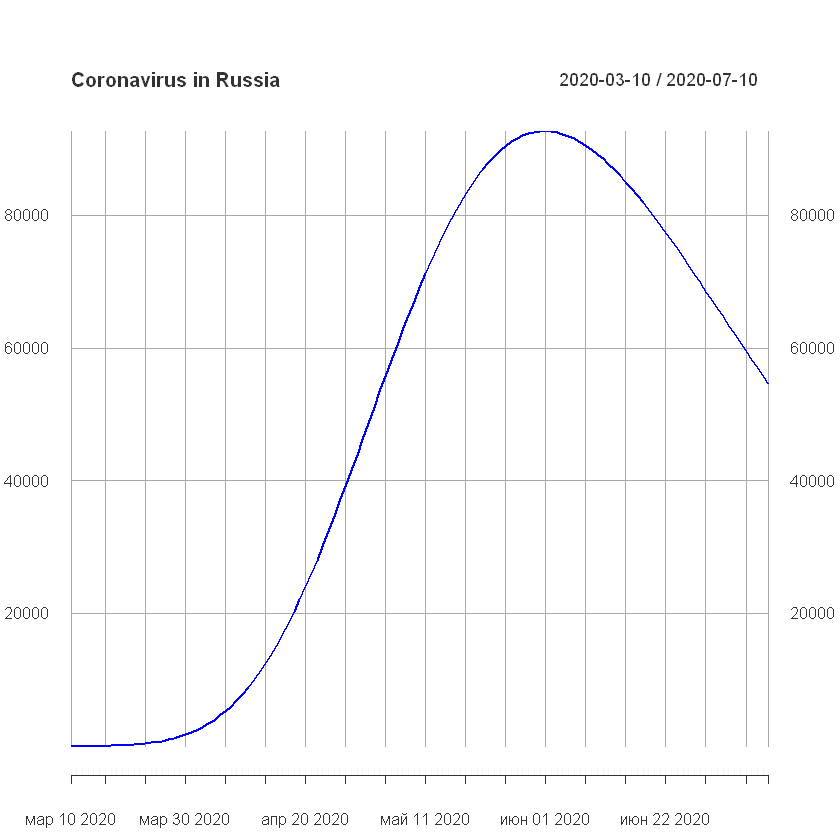

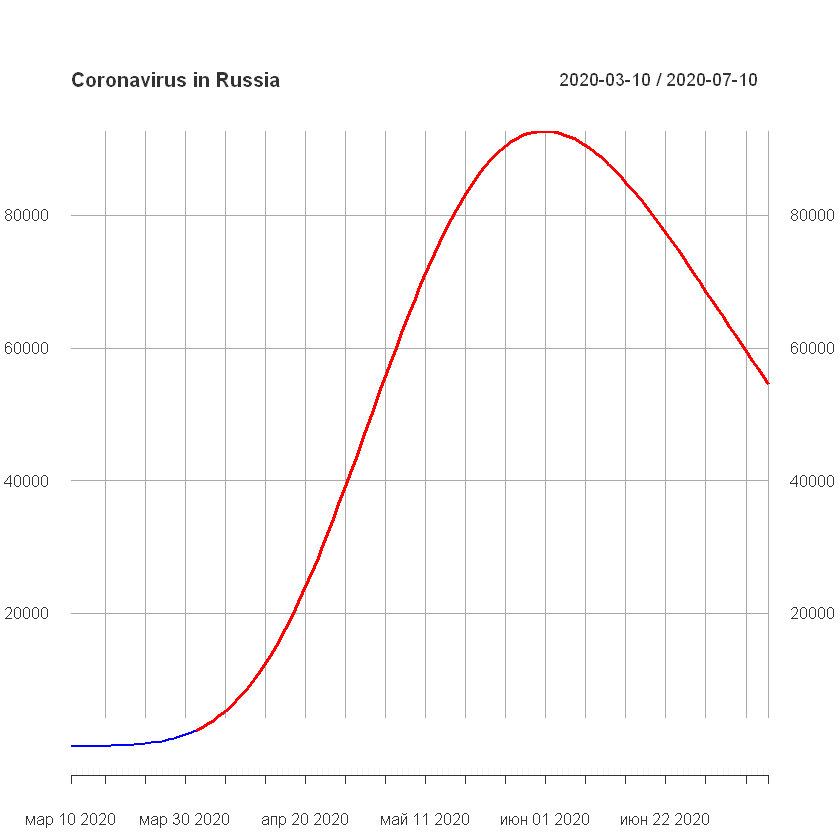

In [68]:
plot(REAL_PRED, col = 'blue', ylab = 'Number of Cases', main = 'Coronavirus in Russia')
lines(REAL_PRED['2020-04-01::'], col = 'red', lwd = 3)

In [69]:
REAL_PRED[which(REAL_PRED == max(REAL_PRED)),]

Warning message:
"timezone of object (UTC) is different than current timezone ()."

            [,1]
2020-06-01 92640